# Downloading, pre-processing and running cNMF on marjanovic et. al 2020 data
1. Obtaining the data and creating AnnData object
2. filtering genes, showing key statistics and selecting joint highly variable genes (jHVGs)
3. Splitting the dataset by timepoints
3. Running consensus NMF (cNMF) per timepoint
4. Selecting parameters for the cNMF
5. Running the comparator for adjacent time points



In [1]:
%%time

#debug jupyter:
%load_ext autoreload
%autoreload 2

#debug IDE:
from importlib import reload

import sys
import os
import time
import warnings
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

sc.settings.n_jobs=-1

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf
from gepdynamics import pfnmf
from gepdynamics import comparator

_utils.cd_proj_home()
print(os.getcwd())


/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 5.23 s, sys: 2.02 s, total: 7.25 s
Wall time: 16 s


### Downloading or loading AnnData object

In [2]:
%%time
results_dir = _utils.set_dir('results')
results_dir = _utils.set_dir(results_dir.joinpath('marjanovic'))
data_dir = _utils.set_dir('data')

orig_adata_path = data_dir.joinpath('marjanovic_mmLungPlate.h5ad')

if not orig_adata_path.exists():  # create the original adata if it doesn't exist
    print('Source AnnData object does not exist, creating it')
    # directories for file download:
    data_dir = _utils.set_dir('data')
    GSE_dir = _utils.set_dir(data_dir.joinpath('GSE154989'))
    
    # GEO server prefix for mmLungPlate SubSeries GSE154989
    ftp_address = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE154nnn/GSE154989/suppl/'

    #filenames
    f_rawCount = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_dSp_rawCountOrig.h5')
    f_geneTable = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_geneTable.csv.gz')
    f_smpTable = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_smpTable.csv.gz')
    f_smp_annot = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_dZ_annot_smpTable.csv.gz')

    ftp_address = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE154nnn/GSE154989/suppl/'

    # downloading if needed:
    if not f_rawCount.exists():
        urlretrieve(ftp_address + f_rawCount.name, f_rawCount)
    
    if not f_geneTable.exists():
        urlretrieve(ftp_address + f_geneTable.name, f_geneTable)
    
    if not f_smpTable.exists():
        urlretrieve(ftp_address + f_smpTable.name, f_smpTable)
    
    if not f_smp_annot.exists():
        urlretrieve(ftp_address + f_smp_annot.name, f_smp_annot)
    
    # reading the files
    sparse_counts = _utils.read_matlab_h5_sparse(f_rawCount)
    
    gene_ids = pd.read_csv(f_geneTable, index_col=None)
    gene_ids.index = gene_ids.ensgID.str.split('.').str[0]
    gene_ids.index.name = None
    smp_ids = pd.read_csv(f_smpTable, index_col=0)
    smp_annotation = pd.read_csv(f_smp_annot, index_col=0)
    
    # constructing the adata
    adata = sc.AnnData(X=sparse_counts.astype(np.float32), var=gene_ids, obs=smp_ids)

    # remove genes with 0 counts
    adata = adata[:, adata.X.sum(axis=0) > 0].copy()
    
    adata.obs['clusterK12'] = smp_annotation.clusterK12.astype('category')
    
    adata.obsm['X_tsne'] = smp_annotation[['tSNE_1', 'tSNE_2']].values
    adata.obsm['X_phate'] = smp_annotation[['phate_1', 'phate_2']].values
    adata.write(orig_adata_path)

    del sparse_counts, gene_ids, smp_ids, smp_annotation
else:
    adata = sc.read_h5ad(orig_adata_path)

adata



CPU times: user 295 ms, sys: 306 ms, total: 601 ms
Wall time: 2.91 s


AnnData object with n_obs × n_vars = 3891 × 46184
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12'
    var: 'geneID', 'ensgID', 'geneSymbol', 'length'
    obsm: 'X_phate', 'X_tsne'

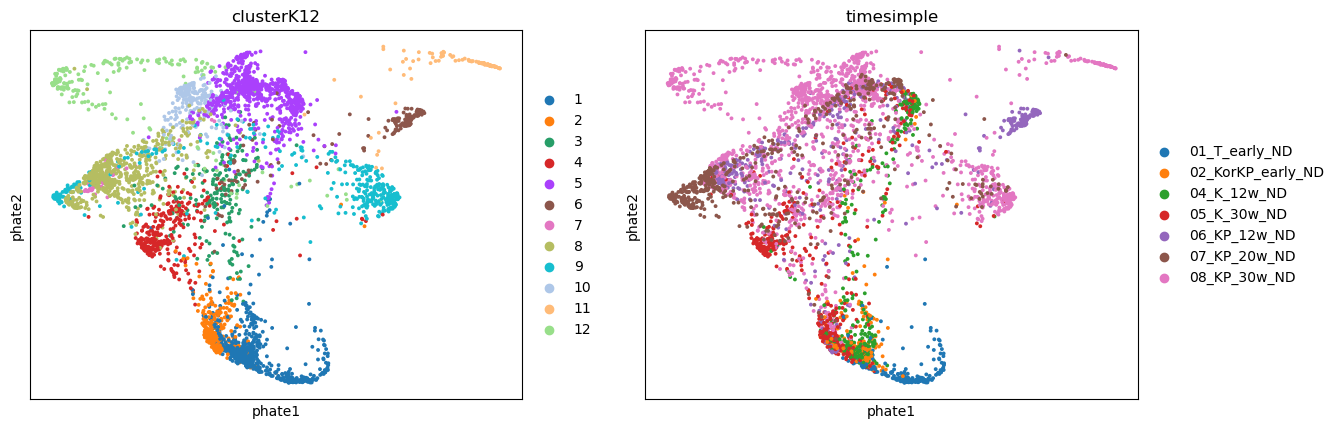

In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.external.pl.phate(adata, color=['clusterK12', 'timesimple'])

adata.uns['timesimple_colors_dict'] = dict(zip(adata.obs['timesimple'].cat.categories, adata.uns['timesimple_colors']))
adata.uns['clusterK12_colors_dict'] = dict(zip(adata.obs['clusterK12'].cat.categories, adata.uns['clusterK12_colors']))

In [4]:
pd.crosstab(adata.obs.timesimple, adata.obs.clusterK12)

clusterK12,1,2,3,4,5,6,7,8,9,10,11,12
timesimple,,,,,,,,,,,,
01_T_early_ND,202,4,0,0,0,0,0,0,0,0,0,0
02_KorKP_early_ND,93,35,7,0,7,0,0,0,0,0,0,0
04_K_12w_ND,240,54,34,8,117,0,0,1,1,0,0,0
05_K_30w_ND,82,133,32,163,71,0,1,15,8,0,0,0
06_KP_12w_ND,4,40,34,17,108,109,8,142,18,9,2,0
07_KP_20w_ND,6,2,13,48,119,10,16,189,134,0,1,0
08_KP_30w_ND,25,17,73,79,343,39,11,270,214,208,86,189


37 mitochondrial genes


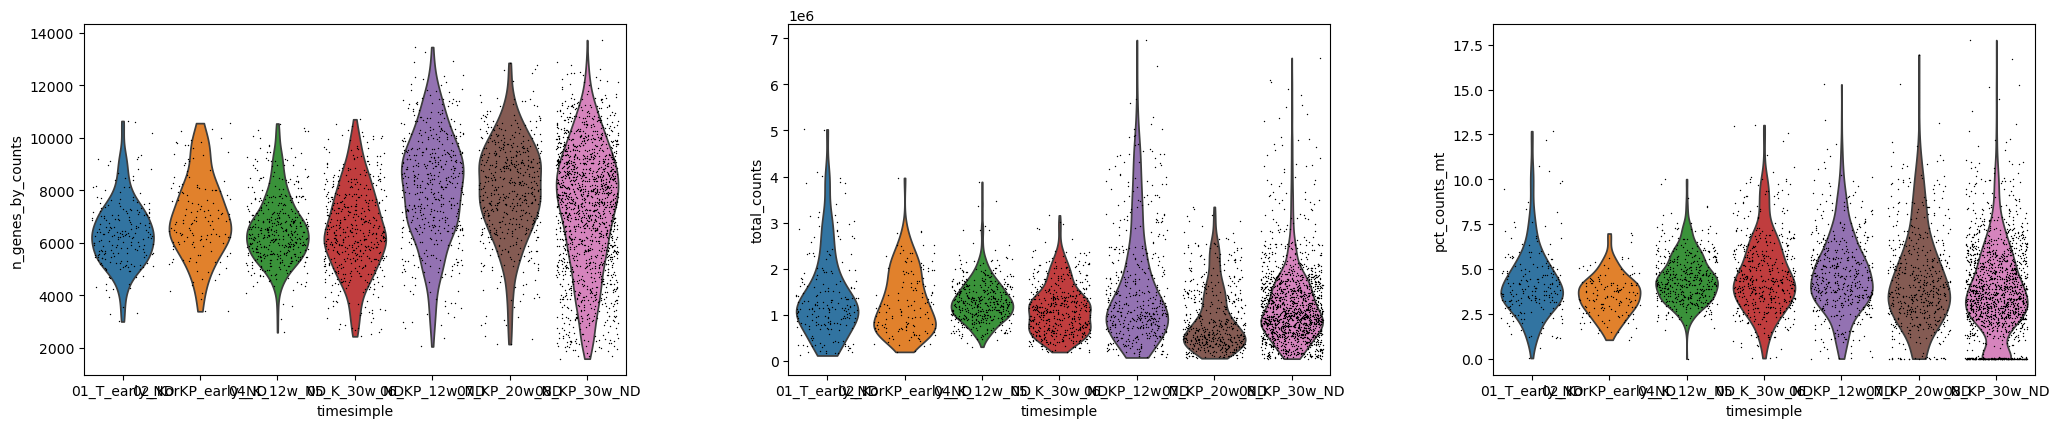

In [5]:
adata.var['mt'] = adata.var.geneSymbol.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
print(f"{np.sum(adata.var['mt'])} mitochondrial genes")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                 jitter=0.4, multi_panel=True, groupby='timesimple')

/tmp/ipykernel_3884998/3987952678.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes_by_counts', 'total_counts']].groupby(
/tmp/ipykernel_3884998/3987952678.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],


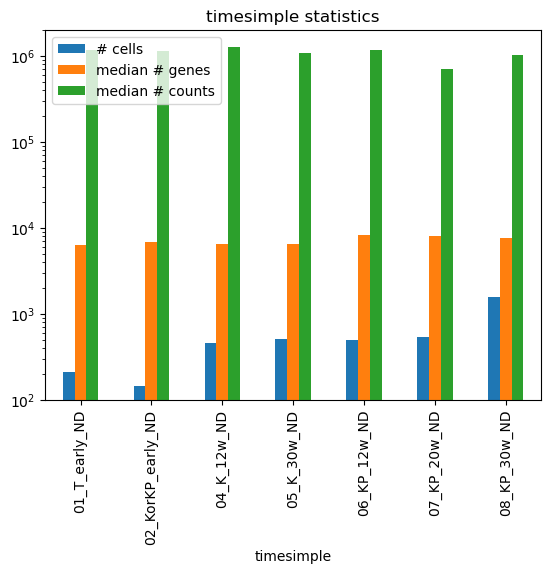

In [6]:
column_of_interest = 'timesimple'

stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes_by_counts', 'total_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((1e2, 2e6)))
plt.show()
del column_of_interest, stats_df

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_qc.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  else adata.var[gene_symbols][top_idx]


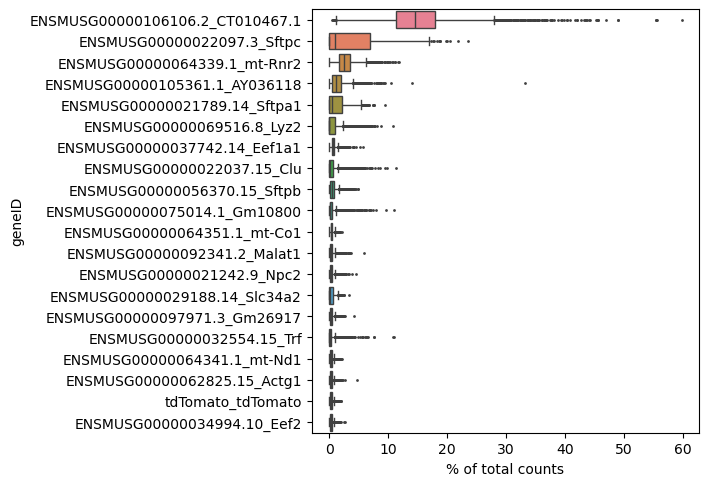

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='geneID')

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


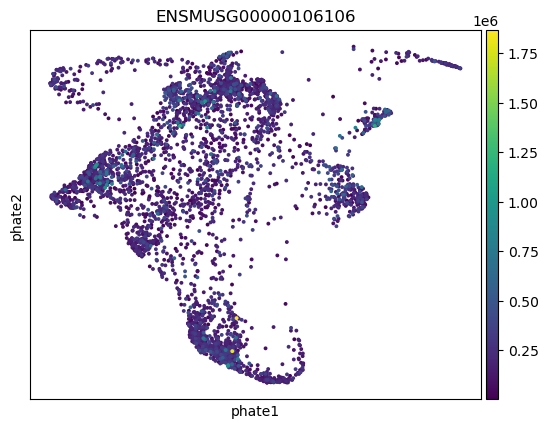

In [8]:
# rRNA overlapping gene 
sc.external.pl.phate(adata, color='ENSMUSG00000106106')

### Filter genes and plot basic statistics
Cells with low number of genes were already filtered

In [9]:
%%time
print(f'before filtering shape was {adata.X.shape}')

# filter cells with high amount of mitochondrial genes or extremely high counts
adata = adata[(adata.obs.pct_counts_mt < 10) & (adata.obs.total_counts < 5E6)].copy()

# filter ribosomal and mitochondrial genes:
adata = adata[:, ~(adata.var.geneSymbol.str.contains('^mt-') |
    adata.var.geneSymbol.str.contains('^Mrp[ls]\d') |
    adata.var.geneSymbol.str.contains('^Rp[ls]\d') |
    (adata.var_names == 'ENSMUSG00000106106'))].copy()

# filtering genes with very low abundance
sc.pp.filter_genes(adata, min_cells=np.round(adata.shape[0] / 1000))

# re-setting general statistics for counts abundance
adata.obs.n_genes_by_counts = np.count_nonzero(adata.X.toarray(), axis=1)
adata.obs.total_counts = adata.X.toarray().sum(axis=1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)

print(f'after filtering shape is {adata.X.shape}')


before filtering shape was (3891, 46184)
after filtering shape is (3797, 37051)
CPU times: user 3.9 s, sys: 1.39 s, total: 5.29 s
Wall time: 4.28 s


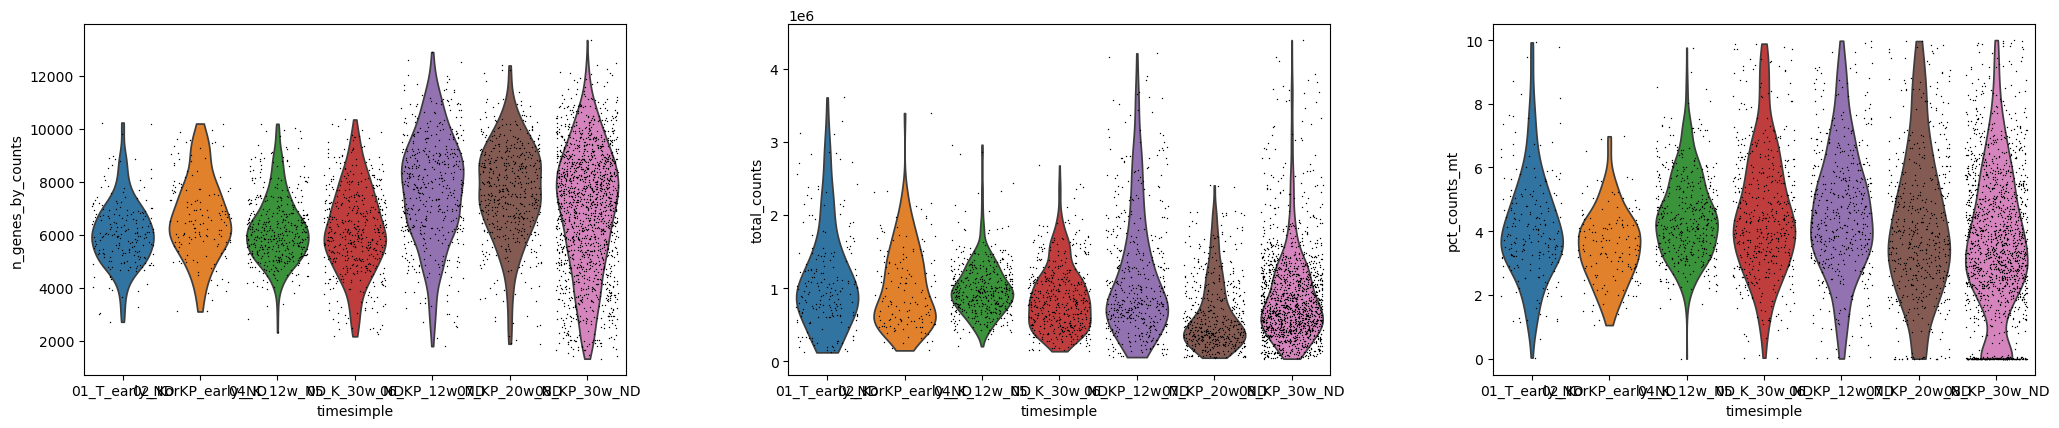

In [12]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                 jitter=0.4, multi_panel=True, groupby='timesimple')

/tmp/ipykernel_3884998/3987952678.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes_by_counts', 'total_counts']].groupby(
/tmp/ipykernel_3884998/3987952678.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],


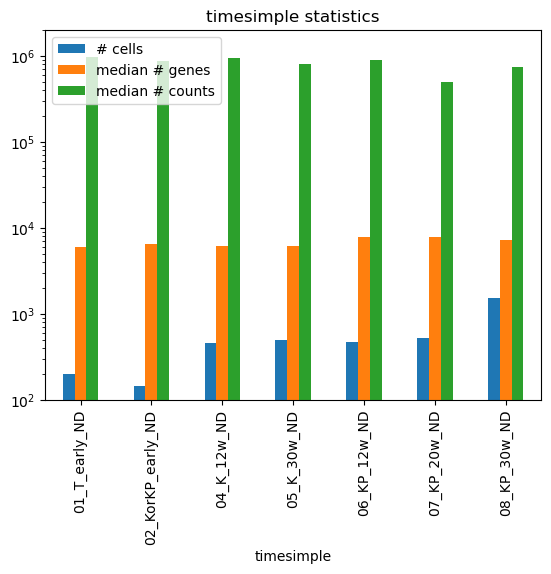

In [13]:
column_of_interest = 'timesimple'

stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes_by_counts', 'total_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((1e2, 2e6)))
plt.show()
del column_of_interest, stats_df

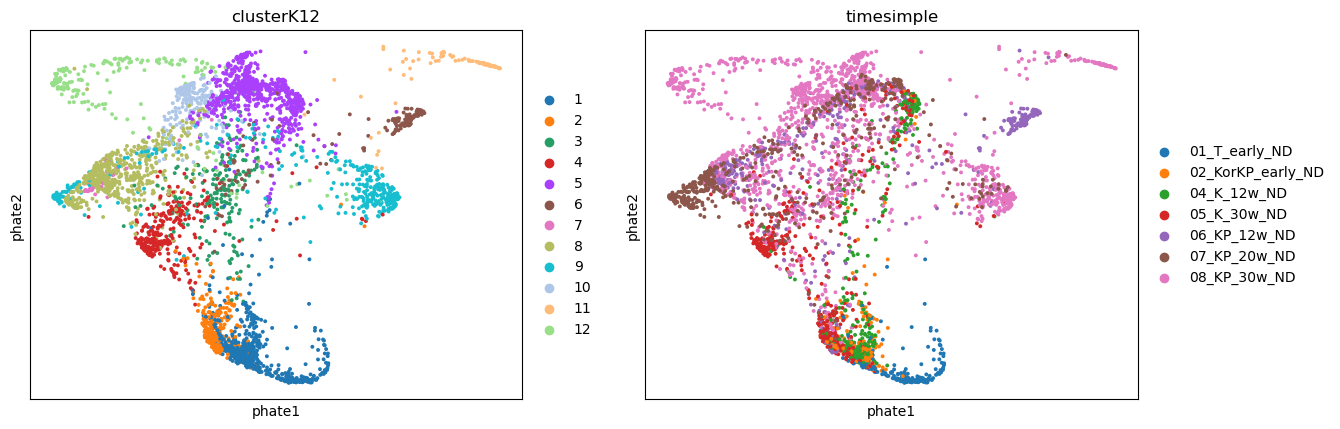

In [14]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.external.pl.phate(adata, color=['clusterK12', 'timesimple'])

In [15]:
pd.crosstab(adata.obs.timesimple, adata.obs.clusterK12)

clusterK12,1,2,3,4,5,6,7,8,9,10,11,12
timesimple,,,,,,,,,,,,
01_T_early_ND,196,4,0,0,0,0,0,0,0,0,0,0
02_KorKP_early_ND,93,35,7,0,7,0,0,0,0,0,0,0
04_K_12w_ND,239,54,34,8,117,0,0,1,1,0,0,0
05_K_30w_ND,82,127,31,161,71,0,1,13,8,0,0,0
06_KP_12w_ND,4,40,33,17,107,104,8,133,17,8,2,0
07_KP_20w_ND,6,2,13,46,118,9,16,176,132,0,1,0
08_KP_30w_ND,24,17,71,77,338,39,9,252,213,201,85,189


In [16]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    _utils.joint_hvg_across_stages(adata, obs_category_key='timesimple', n_top_genes=5000)
adata.var


,geneID,ensgID,geneSymbol,length,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,timesimple_max_var_norm,joint_highly_variable
ENSMUSG00000000001,ENSMUSG00000000001.4_Gnai3,ENSMUSG00000000001.4,Gnai3,3262.000,False,3157,242.593414,18.864045,9.439310e+05,3081,False,NaN,238.487753,1.111309e+05,0.919581,1.125068,False
ENSMUSG00000000003,ENSMUSG00000000003.15_Pbsn,ENSMUSG00000000003.15,Pbsn,799.500,False,5,0.003598,99.871498,1.400000e+01,5,False,NaN,0.003687,1.526564e-02,1.420609,1.420609,False
ENSMUSG00000000028,ENSMUSG00000000028.14_Cdc45,ENSMUSG00000000028.14,Cdc45,1574.000,False,365,8.837885,90.619378,3.438821e+04,351,False,NaN,8.859423,2.363279e+03,1.597923,2.424523,True
ENSMUSG00000000031,ENSMUSG00000000031.15_H19,ENSMUSG00000000031.15,H19,1268.600,False,23,3.876859,99.408892,1.508486e+04,22,True,268.0,3.954137,1.285917e+04,3.929442,3.929442,True
ENSMUSG00000000049,ENSMUSG00000000049.11_Apoh,ENSMUSG00000000049.11,Apoh,665.500,False,155,3.832691,96.016448,1.491300e+04,149,True,775.0,3.800105,1.546848e+03,2.841224,3.084494,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000114962,ENSMUSG00000114962.1_AC126939.4,ENSMUSG00000114962.1,AC126939.4,743.000,False,263,0.005112,93.240812,1.989004e+01,253,False,NaN,0.005180,4.341623e-03,0.213936,0.750709,False
ENSMUSG00000114967,ENSMUSG00000114967.1_AC161884.2,ENSMUSG00000114967.1,AC161884.2,227.000,False,41,0.039324,98.946286,1.530100e+02,40,False,NaN,0.039244,3.912414e-01,0.521800,1.217894,False
ENSMUSG00000114968,ENSMUSG00000114968.1_AC130217.2,ENSMUSG00000114968.1,AC130217.2,2990.000,False,42,0.578473,98.920586,2.250840e+03,41,False,NaN,0.563466,7.400340e+01,2.227440,2.227440,True
kallistoKRASG12D,kallistoKRASG12D_KRASG12D,kallistoKRASG12D,KRASG12D,422.403,False,1201,6.795740,69.133899,2.644224e+04,1162,False,NaN,6.413899,3.660532e+02,0.370166,0.765605,False


In [17]:
prepared_adata_path = results_dir.joinpath('full.h5ad')

if not prepared_adata_path.exists():
    # Removing h5ad trouble saving element before saving
    adata.uns.pop('clusterK12_colors_dict', None)
    adata.write_h5ad(prepared_adata_path)
else:
    print('reading adata...')
    adata = sc.read_h5ad(prepared_adata_path)
    # restoring h5ad trouble saving element
    adata.uns['clusterK12_colors_dict'] = dict(zip(adata.obs['clusterK12'].cat.categories, adata.uns['clusterK12_colors']))

adata

AnnData object with n_obs × n_vars = 3797 × 37051
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'geneID', 'ensgID', 'geneSymbol', 'length', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'timesimple_max_var_norm', 'joint_highly_variable'
    uns: 'clusterK12_colors', 'timesimple_colors', 'timesimple_colors_dict', 'hvg'
    obsm: 'X_phate', 'X_tsne'

### Splitting the adata by "timesimple"

In [52]:
short_names_dict = {
    '01_T_early_ND': 'T0',
    '02_KorKP_early_ND': 'K2',
    '04_K_12w_ND': 'K12',
    '05_K_30w_ND': 'K30',
    '06_KP_12w_ND': 'KP12',
    '07_KP_20w_ND': 'KP20',
    '08_KP_30w_ND': 'KP30'}

In [19]:
%%time

column_of_interest = 'timesimple'
categories = adata.obs[column_of_interest].cat.categories

split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))

for cat in categories:
    if not split_adatas_dir.joinpath(f'{cat}.h5ad').exists():
        print(f'working on {cat}')
        tmp = adata[adata.obs[column_of_interest] == cat].copy()

        tmp.uns['name'] = f'{cat}'   # full name
        tmp.uns['sname'] = short_names_dict[cat]  # short name

        # correcting the gene counts
        sc.pp.filter_genes(tmp, min_cells=0)
        sc.pp.filter_genes(tmp, min_counts=0)
        
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            sc.pp.highly_variable_genes(tmp, flavor='seurat_v3', n_top_genes=5000)

        # Removing h5ad trouble saving element before saving
        tmp.uns.pop('clusterK12_colors_dict', None)
        tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

        del tmp
    else:
        print(f'{cat} split adata exists')

Directory "results/marjanovic/split_timesimple" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/split_timesimple
working on 01_T_early_ND
working on 02_KorKP_early_ND
working on 04_K_12w_ND
working on 05_K_30w_ND
working on 06_KP_12w_ND
working on 07_KP_20w_ND
working on 08_KP_30w_ND
CPU times: user 10.5 s, sys: 876 ms, total: 11.4 s
Wall time: 7.78 s


### Running multiple NMF iterations

In [20]:
cnmf_dir = _utils.set_dir(results_dir.joinpath('cnmf'))


Directory "results/marjanovic/cnmf" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/cnmf


In [21]:
%%time

ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    
    # Variance normalized version of the data
    X = _utils.subset_and_normalize_for_nmf(tmp, method='variance_cap')
    
    c_object.prepare(X, ks, n_iter=120, new_nmf_kwargs={
        'tol': _constants.NMF_TOLERANCE, 'beta_loss': 'kullback-leibler', 'max_iter': 1000})
    
    c_object.factorize(0, 1, gpu=True)
    
    c_object.combine()
    
    del tmp, X

Starting on 01_T_early_ND, time is 12:49:02
Combining factorizations for k=1.
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Starting on 02_KorKP_early_ND, time is 12:55:58
Combining factorizations for k=1.
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Starting on 04_K_12w_ND, time is 13:03:12
Combining factorizations for k=1.
Combining 

In [22]:
%%time
for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, cat)
    for thresh in [0.5, 0.4]:
        print(f'working on threshold {thresh}')
        c_object.k_selection_plot(density_threshold=thresh, nmf_refitting_iters=1000, 
                                  consensus_method='mean',
                                  close_fig=True, show_clustering=True, gpu=True)
        # printing the selected knee point
        df = cnmf.load_df_from_npz(c_object.paths['k_selection_stats_dt'] % c_object.convert_dt_to_str(thresh))
        pos = len(df) - 4
        for i in range(5):
            print(cnmf.find_knee_point(df.prediction_error[:pos + i], df.k_source[:pos + i]), end=", ")
        print()

Starting on 01_T_early_ND, time is 13:57:58
working on threshold 0.5
4.0, 4.0, 4.0, 7.0, 6.0, 
working on threshold 0.4
5.0, 5.0, 5.0, 5.0, 5.0, 
Starting on 02_KorKP_early_ND, time is 13:58:54
working on threshold 0.5
4.0, 4.0, 4.0, 4.0, 4.0, 
working on threshold 0.4
4.0, 3.0, 4.0, 3.0, 6.0, 
Starting on 04_K_12w_ND, time is 13:59:57
working on threshold 0.5
3.0, 4.0, 4.0, 4.0, 4.0, 
working on threshold 0.4
3.0, 3.0, 3.0, 3.0, 3.0, 
Starting on 05_K_30w_ND, time is 14:01:19
working on threshold 0.5
3.0, 4.0, 4.0, 4.0, 4.0, 
working on threshold 0.4
3.0, 4.0, 4.0, 4.0, 4.0, 
Starting on 06_KP_12w_ND, time is 14:02:43
working on threshold 0.5
4.0, 4.0, 4.0, 5.0, 5.0, 
working on threshold 0.4
4.0, 4.0, 4.0, 4.0, 5.0, 
Starting on 07_KP_20w_ND, time is 14:04:17
working on threshold 0.5
3.0, 3.0, 3.0, 5.0, 5.0, 
working on threshold 0.4
3.0, 3.0, 3.0, 5.0, 5.0, 
Starting on 08_KP_30w_ND, time is 14:05:55
working on threshold 0.5
3.0, 4.0, 4.0, 4.0, 5.0, 
working on threshold 0.4
3.0, 4.

## 5. Selecting decomposition ranks for cNMF using knee-point and silhouette


In [24]:
selected_cnmf_params = {
    '01_T_early_ND': (2, 0.5),
    '02_KorKP_early_ND': (4, 0.5),
    '04_K_12w_ND': (4, 0.5),
    '05_K_30w_ND': (4, 0.5),
    '06_KP_12w_ND': (5, 0.5),
    '07_KP_20w_ND': (5, 0.5),
    '08_KP_30w_ND': (5, 0.5)}

selected_cnmf_params

{'01_T_early_ND': (2, 0.5),
 '02_KorKP_early_ND': (4, 0.5),
 '04_K_12w_ND': (4, 0.5),
 '05_K_30w_ND': (4, 0.5),
 '06_KP_12w_ND': (5, 0.5),
 '07_KP_20w_ND': (5, 0.5),
 '08_KP_30w_ND': (5, 0.5)}

In [65]:
%%time

split_adatas = {}
decompositions = {}

for cat, (k, threshold) in selected_cnmf_params.items():
    print(f'Working on {cat} with k={k} and threshold={threshold}')
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                       consensus_method='mean',
                       nmf_refitting_iters=1000, show_clustering=False)

    usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
    
    tmp.uns['cnmf_params'] = {'k_nmf': k, 'threshold': threshold}

    # X ~ W @ H, transpose for cells to be columns
    loss_per_cell = pfnmf.calc_beta_divergence(
        c_object.X.T, W = spectra.T, H = usages.T, per_column=True)

    res = comparator.NMFResult(
        name=f'{tmp.uns["sname"]}_k{k}',
        loss_per_cell=loss_per_cell,
        rank=k,
        W=usages,
        H=spectra)
    
    comparator.NMFResultBase.calculate_gene_coefficients_list(
        tmp, [res], target_sum=1_000_000, target_variance=tmp.var['variances_norm'].values)
    
    decompositions[cat] = {k: res}

    tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

    
    # restoring h5ad trouble saving element
    tmp.uns['clusterK12_colors_dict'] = dict(zip(tmp.obs['clusterK12'].cat.categories, tmp.uns['clusterK12_colors']))

    split_adatas[cat] = tmp
    print()

Working on epi 01_T_early_ND with k=2 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 321030.90625, # iterations was 70
Refitting W, H based on consensus
beta 1 loss = 312644.8125, # iterations was 120

Working on epi 02_KorKP_early_ND with k=4 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 219968.65625, # iterations was 90
Refitting W, H based on consensus
beta 1 loss = 205704.65625, # iterations was 180

Working on epi 04_K_12w_ND with k=4 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 708629.6875, # iterations was 70
Refitting W, H based on consensus
beta 1 loss = 693455.6875, # iterations was 240

Working on epi 05_K_30w_ND with k=4 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 800806.6875, # iterations was 110
Refitting W, H based on consensus
beta 1 loss = 780220.625, # iterations was 170

Working on epi 06_KP_12w_ND with k=5 and threshold=0.5
Updating W based on consensus spectra
beta 1 l

In [83]:
np.savez(results_dir.joinpath('decompositions.npz'), obj=decompositions)

#### Reloading the results

In [73]:
%%time

column_of_interest = 'timesimple'
categories = adata.obs[column_of_interest].cat.categories

split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))

split_adatas = {}
for cat in categories:
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    # restoring h5ad trouble saving element
    tmp.uns['clusterK12_colors_dict'] = dict(zip(tmp.obs['clusterK12'].cat.categories, tmp.uns['clusterK12_colors']))

    split_adatas[cat] = tmp

decompositions = np.load(results_dir.joinpath('decompositions.npz'), allow_pickle=True)['obj'].item()

CPU times: user 691 ms, sys: 125 ms, total: 816 ms
Wall time: 11 s


### Examening results

In [87]:
for cat in categories:
    print(cat)
    res = decompositions[cat][split_adatas[cat].uns['cnmf_params']['k_nmf']]
    with np.printoptions(precision=2, suppress=False):
        print(res.prog_percentages)

01_T_early_ND
[78.81 21.19]
02_KorKP_early_ND
[58.8   9.29 17.72 14.2 ]
04_K_12w_ND
[25.74 52.44  7.64 14.19]
05_K_30w_ND
[19.75 38.85 18.95 22.45]
06_KP_12w_ND
[23.18 17.83 29.1  24.55  5.33]
07_KP_20w_ND
[23.81 34.34  6.9  14.4  20.54]
08_KP_30w_ND
[ 7.47 23.87 19.04 26.88 22.74]


['KP30_k5.p0', 'KP30_k5.p1', 'KP30_k5.p2', 'KP30_k5.p3', 'KP30_k5.p4']

In [88]:
color_obs_by = 'clusterK12'
decomposition_images = _utils.set_dir(split_adatas_dir.joinpath("images"))

with warnings.catch_warnings():  # supress scanpy plotting warning
    warnings.simplefilter(action='ignore', category=UserWarning)
    warnings.simplefilter(action='ignore', category=FutureWarning)

    for cat in categories:
        tmp = split_adatas[cat]
        k = tmp.uns['cnmf_params']['k_nmf']
        res = decompositions[cat][k]
        
        # Phate
        um = sc.external.pl.phate(tmp, color=color_obs_by, s=10, return_fig=True, title=f'{cat}')
        plt.tight_layout()
        um.savefig(decomposition_images.joinpath(f"{cat}_phate_{color_obs_by}.png"), dpi=300)
        plt.close(um)

        # usages clustermap
        un_sns = _utils.plot_usages_norm_clustermaps(
            tmp, normalized_usages=res.norm_usages, columns=res.prog_names,
            title=f'{cat}', show=False, sns_clustermap_params={
                'row_colors': tmp.obs[color_obs_by].map(tmp.uns[f'{color_obs_by}_colors_dict'])})
        un_sns.savefig(decomposition_images.joinpath(f"{cat}_usages_norm.png"),
                       dpi=180, bbox_inches='tight')
        plt.close(un_sns.fig)

        # usages violin plot
        _utils.plot_usages_norm_violin(
            tmp, color_obs_by, save_path=decomposition_images.joinpath(
                f'{cat}_norm_usage_per_lineage.png'))

Directory "results/marjanovic/split_timesimple/images" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/split_timesimple/images


KeyError: 'usages_norm'

## 6. Running comparator on the data


In [76]:
for cat in categories:
    tmp = split_adatas[cat]

    field_1 = color_obs_by

    tmp.obsm['row_colors'] = pd.concat([
        tmp.obs[field_1].map(tmp.uns[f'{field_1}_colors_dict']),
        ], axis=1)

In [75]:
%%time

pairs = [categories[[2,3]], categories[[2,4]], categories[[3,4]], categories[[3,5]], categories[[4,5]]]

for cat_a, cat_b in pairs:
    print(f'comparing {cat_a} and {cat_b}')
    comparison_dir = _utils.set_dir(results_dir.joinpath(f"comparator_{cat_a:.2s}_{cat_b:.2s}"))
    
    adata_a = split_adatas[cat_a]
    adata_b = split_adatas[cat_b]
    
    if os.path.exists(comparison_dir.joinpath('comparator.npz')):
        continue
    #     cmp = comparator.Comparator.load_from_file(comparison_dir.joinpath('comparator.npz'), adata_a, adata_b)
    # else:
    cmp = comparator.Comparator(adata_a, adata_a.obsm['usages'], adata_b, comparison_dir,
                                'torchnmf', device='cuda', max_nmf_iter=1000, verbosity=1,
                               highly_variable_genes='joint_highly_variable',
                               tpm_target_sum=1_000_000)

    print('decomposing')
    cmp.extract_geps_on_jointly_hvgs()
    
    # getting cnmf results
    c_object = cnmf.cNMF(cnmf_dir, cat_b)
    usages_matrices_b = []
    
    threshold = adata_b.uns['cnmf_params']['threshold']
    for k in range(cmp.rank_a, cmp.rank_a + cmp.max_added_rank + 1):
        try:
            usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
        except FileNotFoundError:
            print(f'Calculating consensus NMF for k={k} and threshold={threshold}')
            c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                               consensus_method='mean',
                               nmf_refitting_iters=1000, show_clustering=False)

            usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
        
        usages_matrices_b.append(usages)
    
    cmp.decompose_b(repeats = 5, precalculated_denovo_usage_matrices=usages_matrices_b)
    
    cmp.print_errors()
    
    cmp.examine_adata_a_decomposition_on_jointly_hvgs(35, 3500)
    cmp.examine_adata_b_decompositions(3500, 35, 3500)
    
    cmp.plot_decomposition_comparisons()
    
    cmp.calculate_fingerprints()
    
    print('running GSEA')
    cmp.run_gsea(gene_ids_column_number=1, 
                 gprofiler_kwargs=dict(organism='mmusculus',
                                       sources=['GO:BP', 'WP', 'REAC', 'KEGG']))

    marker_genes = ['Krt8', 'Hopx', 'Klf6', 'Aqp5', 'Sftpa1', 'Sftpb', 'Sftpc',
                'Mki67', 'Top2a', 'Rrm1', 'Rrm2',
                'Sox2', 'Scgb3a2', 'Foxj1', 'Dynlrb2', 'Hoxa5', 'Col5a2', ]
    
    cmp.plot_marker_genes_heatmaps(marker_genes)
    
    cmp.plot_usages_violin('celltype', show=False)
    
    cmp.save_to_file(comparison_dir.joinpath('comparator.npz'))



AnnData object with n_obs × n_vars = 1517 × 30998
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'timesimple_max_var_norm', 'joint_highly_variable'
    uns: 'clusterK12_colors', 'hvg', 'name', 'sname', 'timesimple_colors', 'timesimple_colors_dict', 'cnmf_params', 'clusterK12_colors_dict'
    obsm: 'X_phate', 'X_tsne', 'usages', 'usages_norm'
    varm: 'usage_coefs'

In [86]:
tmp.var

,ensgID,geneSymbol,length,n_cells,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,timesimple_max_var_norm,joint_highly_variable
geneID,,,,,,,,,,,,,,,,,
ENSMUSG00000000001.4_Gnai3,ENSMUSG00000000001.4,Gnai3,3262.000,1283,4.492730e+05,False,NaN,296.158866,1.704791e+05,0.961585,False,3099,243.581085,18.810584,9.297490e+05,1.169391,False
ENSMUSG00000000028.14_Cdc45,ENSMUSG00000000028.14,Cdc45,1574.000,138,1.170390e+04,True,3110.0,7.715161,2.203048e+03,1.809920,False,354,8.839987,90.725701,3.374223e+04,2.447760,True
ENSMUSG00000000031.15_H19,ENSMUSG00000000031.15,H19,1268.600,19,1.496086e+04,True,135.0,9.862136,3.213975e+04,3.765234,False,22,3.933419,99.423631,1.501386e+04,3.951625,True
ENSMUSG00000000049.11_Apoh,ENSMUSG00000000049.11,Apoh,665.500,85,9.682000e+03,True,593.0,6.382334,3.009577e+03,2.566753,False,149,3.780194,96.096411,1.442900e+04,3.110095,True
ENSMUSG00000000056.7_Narf,ENSMUSG00000000056.7,Narf,1785.000,644,6.040200e+04,False,NaN,39.816744,1.245864e+04,1.310277,False,1498,34.677757,60.754519,1.323650e+05,1.310277,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000114960.1_AC115289.2,ENSMUSG00000114960.1,AC115289.2,2803.000,9,1.300000e+01,False,NaN,0.008570,1.509802e-02,0.439673,False,37,0.050241,99.030652,1.917700e+02,2.029375,False
ENSMUSG00000114967.1_AC161884.2,ENSMUSG00000114967.1,AC161884.2,227.000,15,5.000000e+01,False,NaN,0.032960,1.677784e-01,0.498750,False,40,0.039039,98.952057,1.490100e+02,1.242086,False
ENSMUSG00000114968.1_AC130217.2,ENSMUSG00000114968.1,AC130217.2,2990.000,18,6.328600e+02,True,4032.0,0.417179,3.082923e+01,1.681710,False,41,0.560513,98.925858,2.139480e+03,2.290207,True
